# Explaining Hypothesis Tests

This notebook shows how to explain hypothesis tests with general SHAP values.

In this example, we ask why our model believes the risk level of a sample of people with diabetes is unusually likely to exceed some threshold (155).

We find that the features which most convince our model that our sample's average risk level exceeds the threshold are body mass index (BMI) and a medical test (S5).

This question is a specific example of a general question. Suppose we have a sample statistic $s$ and a hypothesis test of this statistic $h$. For a sample of observations $X$, we can ask why our model believes this sample statistic is more likely to satisfy our hypothesis ($h(s(X))$ evaluates to True) than samples drawn from the general population.

Here, the sample statistic is the mean risk level, and the hypothesis is that the mean exceeds the threshold.

In [1]:
import gshap
from gshap.hypothesis import HypothesisTest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

THRESHOLD = 155

We begin by loading the diabetes dataset and training our regressor.

In [2]:
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
reg = Lasso(alpha=.1)
reg.fit(X_train, y_train)
print('Test score: %.4f' % reg.score(X_test, y_test))

Test score: 0.5996


Next, we plot the the training samples along BMI and S5. Samples in red have a risk level above the threshold, increasing the probability of confirming our hypothesis. Samples in blue have a risk level below the threshold, increasing the probability of disconfirming our hypothesis.

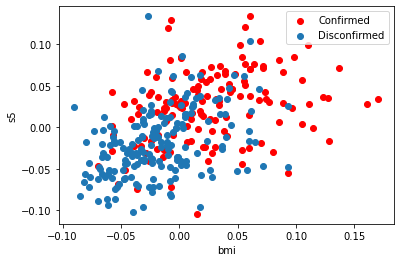

In [3]:
h_conf = y_train > THRESHOLD
X_train_conf = X_train[h_conf]
X_train_dconf = X_train[np.logical_not(h_conf)]

plt.scatter(X_train_conf[:,2], X_train_conf[:,8], c='red', label='Confirmed')
plt.scatter(X_train_dconf[:,2], X_train_dconf[:,8], label='Disconfirmed')
plt.xlabel(diabetes.feature_names[2])
plt.ylabel(diabetes.feature_names[8])
plt.legend()
plt.show()

Compute the G-SHAP values, where $g$ is a `HypothesisTest`. A `HypothesisTest` uses bootstrapping to approximate the probability that the sample statistic satisfies our hypothesis for a sample output.

Here, the sample statistic is the mean predicted risk level, and the hypothesis is confirmed when the mean predicted risk level exceeds the threshold.

In [4]:
statistic = lambda y: y.mean()
test = lambda y_bar: y_bar > THRESHOLD
g = HypothesisTest(statistic, test, bootstrap_samples=100)
explainer = gshap.KernelExplainer(reg.predict, X_train, g)
x = X_test[y_test > 70] # artifically select a sample which with higher-than-average risk
gshap_values = explainer.gshap_values(x, nsamples=100)

For interpretation, we compare our sample to the background dataset in terms of $g$. We see that our sample has a higher probability of satisfying the hypothesis than the background dataset as expected.

The sum of the G-SHAP values should approximately equal the difference between our sample and the background data (allowing for sampling error).

In [5]:
g_comparison, g_background = explainer.compare(x, bootstrap_samples=1000)
print('Probability that the statistic satisfies our hypothesis in our sample: %.4f' % g_comparison)
print('Probability that the statistic satisifes our hypothesis in the background data: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values.sum())

Probability that the statistic satisfies our hypothesis in our sample: 0.9600
Probability that the statistic satisifes our hypothesis in the background data: 0.4020
Sum of G-SHAP values: 0.5628


Finally, we plot our results. This plot tells us which features most convince our model that our sample's mean risk level exceeds the threshold.

More precisely, our model believes that the mean risk level of our sample $x$ exceeds the threshold with probability $p_s$, and that the mean risk level of the background data exceeds the threshold with probability $p_b$. Each G-SHAP value $\phi_j$ is the number of percentage points of this difference $p_s-p_b$ explained by feature $j$.

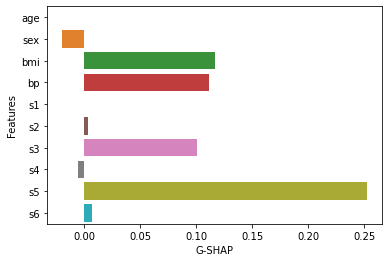

In [6]:
df = pd.DataFrame({
    'Features': list(diabetes.feature_names),
    'G-SHAP': list(gshap_values)
})
sns.barplot(x='G-SHAP', y='Features', data=df)
plt.show()